#Validating Configuration Data:


This Program needed compete Dataset file, Configuration file and Google API key file in Json format.

In [0]:
#Reading configuration file and validating all API keys

import json

In [0]:
with open('config.json','r') as f:
    config_data = f.read()

config = json.loads(config_data)

In [4]:
#Validating AWS Credentials
!pip install botocore
import botocore.session

access_key = config['AWS Access Keys']
secret_access_key = config['AWS Secret Keys']

session = botocore.session.get_session()

sts = session.create_client('sts', aws_access_key_id=access_key,aws_secret_access_key=secret_access_key)

response = sts.get_caller_identity()

if response['ResponseMetadata']['HTTPStatusCode'] == 200:
    print('AWS Credentials are valid!')
    #Proceed to next validation
else:
    print('AWS Credentials are Invalid')
    #Exit code

    100% |████████████████████████████████| 5.1MB 7.5MB/s 
    100% |████████████████████████████████| 552kB 24.7MB/s 
AWS Credentials are valid!


In [6]:
#Validating Microsoft Azure API connections
from http.client import HTTPSConnection


uri = config['MS Azure Region']+'.api.cognitive.microsoft.com'
accessKey = config['MS Azure Access Keys']

test_doc = {'documents' : [
  {'id': '1', 'language': 'en', 'text': 'This is test data!'}
]}

def GetSentiment (documents):
    path = '/text/analytics/v2.0/sentiment'
    
    headers = {'Ocp-Apim-Subscription-Key': accessKey}
    conn = HTTPSConnection (uri)
    body = json.dumps (documents)
    conn.request ("POST", path, body, headers)
    response = conn.getresponse ()
    return response

result = GetSentiment(test_doc)

if result.status == 200:
    print('Microsoft Keys are valid!')
    #Proceed with other validation
else :
    print('Microsoft Keys are Invalid!')
    #Exit code

Microsoft Keys are valid!


In [10]:
#Validating IBM API keys

#Introducing IBM API:
!pip install watson_developer_cloud
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, SentimentOptions

natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2018-03-16',
    iam_apikey=config['IBM API Key'],
    url=config['IBM API url']
)
response = natural_language_understanding.analyze(
    text='This is test text',
    features=Features(sentiment=SentimentOptions(targets=[''])))

if response.get_status_code() == 200:
    print('IBM keys are valid!')
    #Proceed with other validation
else :
    print('IBM Keys are Invalid!')
    #Exit code

IBM keys are valid!


In [23]:
#Valdating Google API Keys:

from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

from google.oauth2 import service_account

cred = service_account.Credentials.from_service_account_file('NLP-Sentiment-3ab1018e6990.json')

client = language.LanguageServiceClient(credentials=cred)

data = ['This is the best day of my life!']

for text in data:
  document = types.Document(
    content=text,
    type=enums.Document.Type.PLAIN_TEXT)
  sentiment = client.analyze_sentiment(document=document)


  if sentiment.language == "en":
    print("Google API Keys are valid!")
  else:
    print("Invalid Google API Keys!")

Google API Keys are valid!


In [0]:
#Here we will merge all the data from all the team to get the complete dataset with manual sentiment analysis:

with open('data.json','r') as f:
    data_all = f.read()
    
data = json.loads(data_all)

In [0]:
#This is the list of Text
X = list(data['Text'].values())
#This is the list of Manual Sentiment
Y = list(data['Sentiment'].values())
#This is the list for Company name
Z = list(data['Company'].values())

In [0]:
import pandas as pd

In [0]:
Man_Senti = pd.DataFrame({'Text':X, 'Sentiment': Y, 'Company': Z})

In [80]:
Man_Senti.head()

,Company,Sentiment,Text
0,Amazon,Neutral,"Amazon.com, Inc. (NASDAQ:AMZN) Q3 2018 Earning..."
1,Amazon,Neutral,"Good day, everyone, and welcome to the Amazon...."
2,Amazon,Neutral,"For opening remarks, I will be turning the cal..."
3,Amazon,Neutral,"Hello, and welcome to our Q3 2018 financial re..."
4,Amazon,Neutral,Our comments and responses to your questions r...


In [109]:
len(Man_Senti)

622

In [82]:
text = X

from time import time
!pip install boto3
import boto3

In [0]:
#Getting sentiment using AWS API:

start = time()

comprehend = boto3.client(
    'comprehend',
    aws_access_key_id=access_key,
    aws_secret_access_key=secret_access_key,
    region_name='us-east-1'
)

rows = []
i=1
for t in text:
  sentimentData = comprehend.detect_sentiment(Text=t, LanguageCode='en')
  row = [i, 'AWS', sentimentData['Sentiment'],sentimentData['SentimentScore']['Negative'],sentimentData['SentimentScore']['Neutral'],sentimentData['SentimentScore']['Positive']]
  rows.append(row)
  i+=1
result_aws = pd.DataFrame(rows, columns=['Text_ID', 'API', 'Overall', 'Negative', 'Neutral', 'Positive'])

end = time()

time_aws = end - start


In [151]:
#AWS Sentiment 
result_aws.head()

,Text_ID,API,Overall,Negative,Neutral,Positive
0,1,AWS,NEUTRAL,0.000141,0.998418,0.001304
1,2,AWS,POSITIVE,0.003760,0.487941,0.495716
2,3,AWS,NEUTRAL,0.007338,0.976732,0.012431
3,4,AWS,NEUTRAL,0.000654,0.686703,0.305323
4,5,AWS,NEUTRAL,0.002042,0.996204,0.001183


In [152]:
time_aws

62.86798977851868

In [153]:
len(result_aws)

622

In [0]:
#Getting sentiment using Microsoft Azure API:

n = len(text)
id=[i for i in range(1,1+n)]
language=['en' for i in range(n)]
document=[]

#Generating form for hitting it on Azure Text Analystics API 
for i in range(n):
    dic = {'id':id[i],'language':language[i],'text':text[i]}
    document.append(dic)
documents = {'documents':document}

def GetSentiment (documents1):
    path = '/text/analytics/v2.0/sentiment'
    
    headers = {'Ocp-Apim-Subscription-Key': accessKey}
    conn = HTTPSConnection (uri)
    body = json.dumps (documents1)
    conn.request ("POST", path, body, headers)
    response = conn.getresponse ()
    return response.read ()
  
start = time()
result = GetSentiment(documents)

sentiments = json.loads(result)["documents"]

i = 0
rows = []
for item in sentiments:
  row = [sentiments[i]['id'], 'Azure', sentiments[i]['score']]
  rows.append(row)
  i+=1
result_azure = pd.DataFrame(rows, columns=['Text_ID', 'API', 'Overall_Score'])

end = time()

time_azure = end - start

In [89]:
result_azure.head()

,Text_ID,API,Overall_Score
0,1,Azure,0.500000
1,2,Azure,0.891742
2,3,Azure,0.500000
3,4,Azure,0.500000
4,5,Azure,0.500000


In [90]:
time_azure

3.167090654373169

In [92]:
len(result_azure)

622

In [95]:
#Getting sentiment using IBM API:

#Introducing IBM API:
!pip install watson_developer_cloud
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, SentimentOptions

natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2018-03-16',
    iam_apikey=config['IBM API Key'],#need private key here
    url=config['IBM API url']
)

start = time()
rows = []
i=1
for t in text:
    if (len(t)<15 or len(t.split(' '))<3):
        #Padding neutral text as the IBM NLU api needs some minimum text word and charachater coun
        t = t + "This is neutral"
    sentimentData = natural_language_understanding.analyze(text=t,features=Features(sentiment=SentimentOptions(targets=['']))).get_result()
    row = [i, 'IBM', sentimentData['sentiment']['document']['label'],sentimentData['sentiment']['document']['score']]
    rows.append(row)
    i+=1
    
result_ibm = pd.DataFrame(rows, columns=['Text_ID', 'API', 'Overall', 'Score'])

end = time()

time_ibm = end - start

In [96]:
result_ibm.head()

,Text_ID,API,Overall,Score
0,1,IBM,neutral,0.000000
1,2,IBM,positive,0.750129
2,3,IBM,positive,0.476440
3,4,IBM,positive,0.678515
4,5,IBM,positive,0.437226


In [97]:
time_ibm

229.88341784477234

In [98]:
len(result_ibm)

622

In [0]:
#Getting Sentiment using Google API:

start = time()

rows = []
i=1

for t in text:
  document = types.Document(
    content=t,
    type=enums.Document.Type.PLAIN_TEXT)
  sentiment = client.analyze_sentiment(document=document)
  row = [i, 'GCP', sentiment.document_sentiment.magnitude,sentiment.document_sentiment.score]
  rows.append(row)
  i+=1

result_gcp = pd.DataFrame(rows, columns=['Text_ID', 'API', 'Magnitude', 'Score'])

end = time()

time_gcp = end-start
  

In [100]:
result_gcp.head()

,Text_ID,API,Magnitude,Score
0,1,GCP,0.0,0.0
1,2,GCP,0.9,0.1
2,3,GCP,0.0,0.0
3,4,GCP,1.2,0.3
4,5,GCP,0.2,0.0


In [101]:
time_gcp

47.409239530563354

In [102]:
len(result_gcp)

622

In [104]:
#Getting Sentiment using Vedor API:

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


analyzer = SentimentIntensityAnalyzer()

start = time()

rows = []
i=1
for t in text:
  sentimentData = analyzer.polarity_scores(t)
  row = [i, 'Vader', sentimentData['compound'],sentimentData['neg'],sentimentData['neu'],sentimentData['pos']]
  rows.append(row)
  i+=1
  
result_vader = pd.DataFrame(rows, columns=['Text_ID', 'API', 'Overall_Score', 'Negative_Score', 'Neutral_Score', 'Positive_Score'])

end = time()

time_vader = end - start



    100% |████████████████████████████████| 133kB 6.0MB/s 


In [105]:
result_vader.head()

,Text_ID,API,Overall_Score,Negative_Score,Neutral_Score,Positive_Score
0,1,Vader,0.0000,0.0,1.000,0.000
1,2,Vader,0.7096,0.0,0.848,0.152
2,3,Vader,0.3182,0.0,0.892,0.108
3,4,Vader,0.8658,0.0,0.872,0.128
4,5,Vader,0.0000,0.0,1.000,0.000


In [227]:
time_vader

0.7608842849731445

In [110]:
len(result_vader)

622

In [111]:
Man_Senti.head()

,Company,Sentiment,Text
0,Amazon,Neutral,"Amazon.com, Inc. (NASDAQ:AMZN) Q3 2018 Earning..."
1,Amazon,Neutral,"Good day, everyone, and welcome to the Amazon...."
2,Amazon,Neutral,"For opening remarks, I will be turning the cal..."
3,Amazon,Neutral,"Hello, and welcome to our Q3 2018 financial re..."
4,Amazon,Neutral,Our comments and responses to your questions r...


In [0]:
Man_Senti = Man_Senti.reset_index()

In [113]:
Man_Senti.head()

,index,Company,Sentiment,Text
0,0,Amazon,Neutral,"Amazon.com, Inc. (NASDAQ:AMZN) Q3 2018 Earning..."
1,1,Amazon,Neutral,"Good day, everyone, and welcome to the Amazon...."
2,2,Amazon,Neutral,"For opening remarks, I will be turning the cal..."
3,3,Amazon,Neutral,"Hello, and welcome to our Q3 2018 financial re..."
4,4,Amazon,Neutral,Our comments and responses to your questions r...


In [0]:
Man_Senti['Text_ID'] = Man_Senti.index + 1

In [115]:
Man_Senti.head()

,index,Company,Sentiment,Text,Text_ID
0,0,Amazon,Neutral,"Amazon.com, Inc. (NASDAQ:AMZN) Q3 2018 Earning...",1
1,1,Amazon,Neutral,"Good day, everyone, and welcome to the Amazon....",2
2,2,Amazon,Neutral,"For opening remarks, I will be turning the cal...",3
3,3,Amazon,Neutral,"Hello, and welcome to our Q3 2018 financial re...",4
4,4,Amazon,Neutral,Our comments and responses to your questions r...,5


In [0]:
Man_Senti = Man_Senti[['Text_ID','Company','Text','Sentiment']]

In [118]:
Man_Senti.head()

,Text_ID,Company,Text,Sentiment
0,1,Amazon,"Amazon.com, Inc. (NASDAQ:AMZN) Q3 2018 Earning...",Neutral
1,2,Amazon,"Good day, everyone, and welcome to the Amazon....",Neutral
2,3,Amazon,"For opening remarks, I will be turning the cal...",Neutral
3,4,Amazon,"Hello, and welcome to our Q3 2018 financial re...",Neutral
4,5,Amazon,Our comments and responses to your questions r...,Neutral


In [134]:
#Now we will normalize the different API Results:

Man_Senti.groupby('Sentiment')['Sentiment'].count()


Sentiment
Negative     62
Neutral     243
Positive    317
Name: Sentiment, dtype: int64

In [135]:
#1. AWS

result_aws.Overall.unique()

array(['NEUTRAL', 'POSITIVE', 'MIXED', 'NEGATIVE'], dtype=object)

In [136]:
result_aws.groupby('Overall')['Overall'].count()

Overall
MIXED         5
NEGATIVE     22
NEUTRAL     385
POSITIVE    210
Name: Overall, dtype: int64

In [0]:
#Now we will replace MIXED with NEUTRAL

backup_result_aws = result_aws.copy()
backup_result_azure = result_azure.copy()
backup_result_ibm = result_ibm.copy()
backup_result_gcp = result_gcp.copy()
backup_result_vader = result_vader.copy()


In [157]:
result_aws.head()

,Text_ID,API,Overall,Negative,Neutral,Positive
0,1,AWS,NEUTRAL,0.000141,0.998418,0.001304
1,2,AWS,POSITIVE,0.003760,0.487941,0.495716
2,3,AWS,NEUTRAL,0.007338,0.976732,0.012431
3,4,AWS,NEUTRAL,0.000654,0.686703,0.305323
4,5,AWS,NEUTRAL,0.002042,0.996204,0.001183


In [0]:
result_aws['Overall'] = result_aws['Overall'].apply({'MIXED':'Neutral', 'NEUTRAL':'Neutral', 'POSITIVE':'Positive', 'NEGATIVE':'Negative'}.get)

In [159]:
result_aws.head()

,Text_ID,API,Overall,Negative,Neutral,Positive
0,1,AWS,Neutral,0.000141,0.998418,0.001304
1,2,AWS,Positive,0.003760,0.487941,0.495716
2,3,AWS,Neutral,0.007338,0.976732,0.012431
3,4,AWS,Neutral,0.000654,0.686703,0.305323
4,5,AWS,Neutral,0.002042,0.996204,0.001183


In [160]:
result_aws.groupby('Overall')['Overall'].count()

Overall
Negative     22
Neutral     390
Positive    210
Name: Overall, dtype: int64

In [0]:
y_true = Man_Senti['Sentiment']
y_pred_aws = result_aws['Overall']

class_names = ['Positive', 'Negative', 'Neutral']

Accuracy Score:  0.43086816720257237
Predicted  Negative  Neutral  Positive  __all__
Actual                                         
Negative          4       49         9       62
Neutral          12      147        84      243
Positive          6      194       117      317
__all__          22      390       210      622


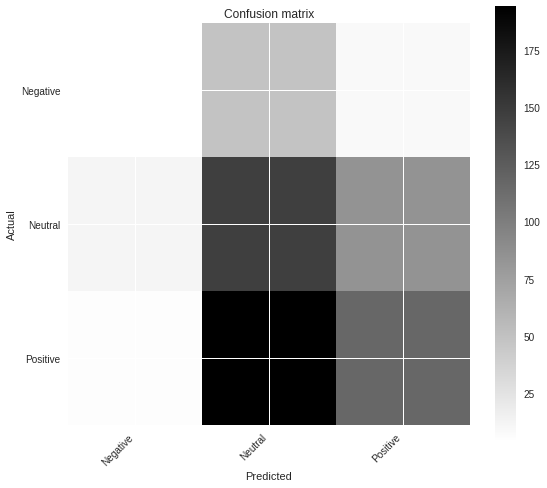

In [174]:
#from sklearn.metrics import confusion_matrix
#!pip install pandas_ml
from pandas_ml import ConfusionMatrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt

# Compute confusion matrix with Manual Sentiment analysis and result from AWS API:

cnf_matrix_aws = ConfusionMatrix(y_true, y_pred_aws)
acc_score_aws = accuracy_score(y_true, y_pred_aws)


print('Accuracy Score: ', acc_score_aws)

print(cnf_matrix_aws)

cnf_matrix_aws.plot()
plt.set_cmap()
plt.show()

In [175]:
# Now lets generalize the Microsoft Azure API result:

result_azure.head()

,Text_ID,API,Overall_Score
0,1,Azure,0.500000
1,2,Azure,0.891742
2,3,Azure,0.500000
3,4,Azure,0.500000
4,5,Azure,0.500000


In [180]:
result_azure.describe()

,Overall_Score
count,622.000000
mean,0.679342
std,0.214881
min,0.073598
25%,0.500000
50%,0.728271
75%,0.891567
max,0.996237


In [0]:
result_azure['Sentiment_Azure'] = 'Neutral'

In [0]:
result_azure.loc[result_azure['Overall_Score'] > 0.55, 'Sentiment_Azure'] = 'Positive'
result_azure.loc[result_azure['Overall_Score'] < 0.45, 'Sentiment_Azure'] = 'Negative'

In [186]:
result_azure.head()

,Text_ID,API,Overall_Score,Sentiment_Azure
0,1,Azure,0.500000,Neutral
1,2,Azure,0.891742,Positive
2,3,Azure,0.500000,Neutral
3,4,Azure,0.500000,Neutral
4,5,Azure,0.500000,Neutral


In [188]:
result_azure.groupby('Sentiment_Azure')['Sentiment_Azure'].count()

Sentiment_Azure
Negative     27
Neutral     276
Positive    319
Name: Sentiment_Azure, dtype: int64

In [0]:
y_pred_azure = result_azure['Sentiment_Azure']

Accuracy Score:  0.45980707395498394
Predicted  Negative  Neutral  Positive  __all__
Actual                                         
Negative          9       35        18       62
Neutral           5      107       131      243
Positive         13      134       170      317
__all__          27      276       319      622


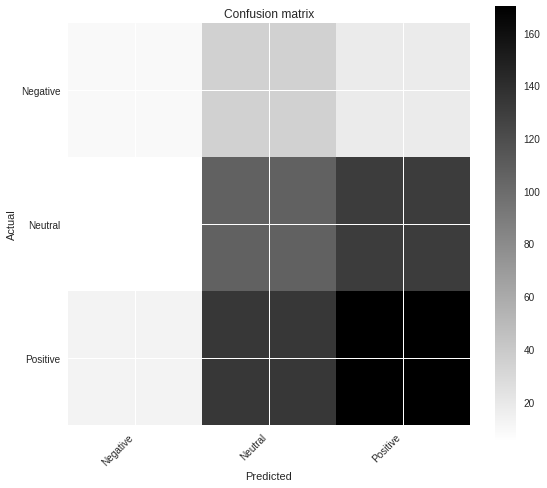

In [191]:
cnf_matrix_azure = ConfusionMatrix(y_true, y_pred_azure)
acc_score_azure = accuracy_score(y_true, y_pred_azure)


print('Accuracy Score: ', acc_score_azure)

print(cnf_matrix_azure)

cnf_matrix_azure.plot()
plt.show()

In [192]:
#Now we will normalize the sentiment result from IBM API:
result_ibm.head()

,Text_ID,API,Overall,Score
0,1,IBM,neutral,0.000000
1,2,IBM,positive,0.750129
2,3,IBM,positive,0.476440
3,4,IBM,positive,0.678515
4,5,IBM,positive,0.437226


In [193]:
result_ibm.describe()

,Text_ID,Score
count,622.000000,622.000000
mean,311.500000,0.592201
std,179.700213,0.419350
min,1.000000,-0.906956
25%,156.250000,0.512123
50%,311.500000,0.730927
75%,466.750000,0.866308
max,622.000000,0.999878


In [195]:
result_ibm.groupby('Overall')['Overall'].count()

Overall
negative     60
neutral      21
positive    541
Name: Overall, dtype: int64

In [199]:
result_ibm.Overall.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [0]:
result_ibm['Overall'] = result_ibm['Overall'].apply({'neutral':'Neutral', 'positive':'Positive', 'negative':'Negative'}.get)

In [201]:
result_ibm.Overall.unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [0]:
y_pred_ibm = result_ibm['Overall']

Accuracy Score:  0.5289389067524116
Predicted  Negative  Neutral  Positive  __all__
Actual                                         
Negative         18        0        44       62
Neutral          17       20       206      243
Positive         25        1       291      317
__all__          60       21       541      622


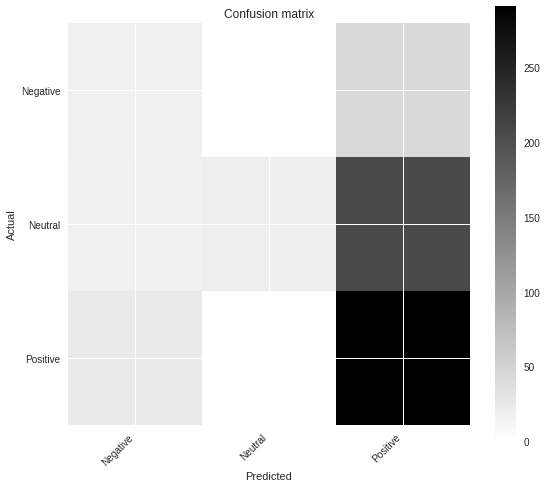

In [203]:
cnf_matrix_ibm = ConfusionMatrix(y_true, y_pred_ibm)
acc_score_ibm = accuracy_score(y_true, y_pred_ibm)


print('Accuracy Score: ', acc_score_ibm)

print(cnf_matrix_ibm)

cnf_matrix_ibm.plot()
plt.show()

In [204]:
#Now we will normalize the sentiment score from Google API:
result_gcp.head()

,Text_ID,API,Magnitude,Score
0,1,GCP,0.0,0.0
1,2,GCP,0.9,0.1
2,3,GCP,0.0,0.0
3,4,GCP,1.2,0.3
4,5,GCP,0.2,0.0


In [205]:
#The magnitude shows the intensity or magnitude value of that sentence
#A magnitude is a number ranging from 0 to infinity. It represents the weight of sentiment expressed in the statement, 
#regardless of being positive or negative. Longer blocks of text with heavily weighted statements have higher magnitude values.
#The Sentiment score is a number and ranges from -1 to +1.

result_gcp.describe()

,Text_ID,Magnitude,Score
count,622.000000,622.000000,622.000000
mean,311.500000,1.126527,0.187460
std,179.700213,0.833413,0.234957
min,1.000000,0.000000,-0.700000
25%,156.250000,0.500000,0.000000
50%,311.500000,1.000000,0.200000
75%,466.750000,1.500000,0.300000
max,622.000000,4.700000,0.900000


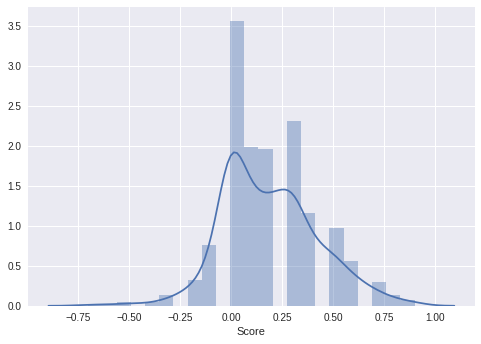

In [208]:
import seaborn as sns

sns.distplot(result_gcp['Score'])

#Conclusion:
1. The Score mean is 0.187 which is less than 50 percentile of data.
2. 75% of data has the less than 0.3
3. Which implies that we need to make a good call to decide the threshold for the sentiment classification.

In [0]:
result_gcp['Sentiment_Google'] = 'Neutral'
result_gcp.loc[result_gcp['Score'] > 0.2, 'Sentiment_Google'] = 'Positive'
result_gcp.loc[result_gcp['Score'] < 0.0, 'Sentiment_Google'] = 'Negative'

In [211]:
result_gcp.head()

,Text_ID,API,Magnitude,Score,Sentiment_Google
0,1,GCP,0.0,0.0,Neutral
1,2,GCP,0.9,0.1,Neutral
2,3,GCP,0.0,0.0,Neutral
3,4,GCP,1.2,0.3,Positive
4,5,GCP,0.2,0.0,Neutral


In [212]:
result_gcp.groupby('Sentiment_Google')['Sentiment_Google'].count()

Sentiment_Google
Negative     59
Neutral     240
Positive    323
Name: Sentiment_Google, dtype: int64

In [0]:
y_pred_gcp = result_gcp['Sentiment_Google']

Accuracy Score:  0.5401929260450161
Predicted  Negative  Neutral  Positive  __all__
Actual                                         
Negative          8       34        20       62
Neutral          24      122        97      243
Positive         27       84       206      317
__all__          59      240       323      622


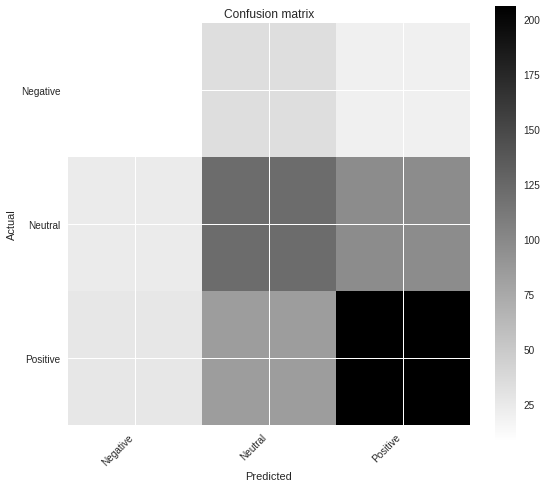

In [214]:
cnf_matrix_gcp = ConfusionMatrix(y_true, y_pred_gcp)
acc_score_gcp = accuracy_score(y_true, y_pred_gcp)


print('Accuracy Score: ', acc_score_gcp)

print(cnf_matrix_gcp)

cnf_matrix_gcp.plot()
plt.show()

In [215]:
#Now we will normalize the sentiment result from the Vader API:
result_vader.head()

,Text_ID,API,Overall_Score,Negative_Score,Neutral_Score,Positive_Score
0,1,Vader,0.0000,0.0,1.000,0.000
1,2,Vader,0.7096,0.0,0.848,0.152
2,3,Vader,0.3182,0.0,0.892,0.108
3,4,Vader,0.8658,0.0,0.872,0.128
4,5,Vader,0.0000,0.0,1.000,0.000


In [216]:
result_vader.describe()

,Text_ID,Overall_Score,Negative_Score,Neutral_Score,Positive_Score
count,622.000000,622.000000,622.000000,622.000000,622.000000
mean,311.500000,0.677799,0.010027,0.846725,0.143240
std,179.700213,0.323263,0.022349,0.082112,0.080211
min,1.000000,-0.606000,0.000000,0.598000,0.000000
25%,156.250000,0.557400,0.000000,0.788000,0.088000
50%,311.500000,0.798700,0.000000,0.849000,0.139000
75%,466.750000,0.913575,0.000000,0.904000,0.200000
max,622.000000,0.994600,0.165000,1.000000,0.402000


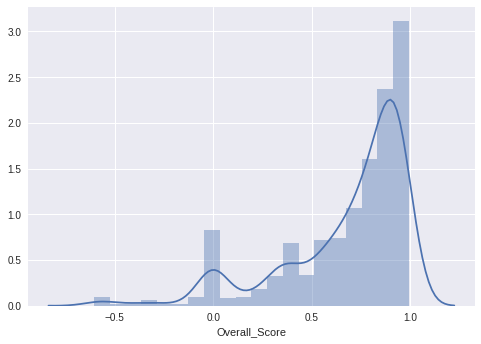

In [217]:
sns.distplot(result_vader['Overall_Score'])

#Conclusion:
1. The above plot show that the Overall score is positively scewed.
2. The range for Overall score is -0.6 to +0.99.
3. By considering the 50 and 75 percentile of Overall score we can choose the threshold for the sentiment.


In [0]:
result_vader['Sentiment_Vader'] = 'Neutral'
result_vader.loc[result_vader['Overall_Score'] > 0.55, 'Sentiment_Vader'] = 'Positive'
result_vader.loc[result_vader['Overall_Score'] < 0.0, 'Sentiment_Vader'] = 'Negative'

In [219]:
result_vader.head()

,Text_ID,API,Overall_Score,Negative_Score,Neutral_Score,Positive_Score,Sentiment_Vader
0,1,Vader,0.0000,0.0,1.000,0.000,Neutral
1,2,Vader,0.7096,0.0,0.848,0.152,Positive
2,3,Vader,0.3182,0.0,0.892,0.108,Neutral
3,4,Vader,0.8658,0.0,0.872,0.128,Positive
4,5,Vader,0.0000,0.0,1.000,0.000,Neutral


In [220]:
result_vader.groupby('Sentiment_Vader')['Sentiment_Vader'].count()

Sentiment_Vader
Negative     17
Neutral     138
Positive    467
Name: Sentiment_Vader, dtype: int64

In [0]:
y_pred_vader = result_vader['Sentiment_Vader']

Accuracy Score:  0.5755627009646302
Predicted  Negative  Neutral  Positive  __all__
Actual                                         
Negative          6       18        38       62
Neutral           6       80       157      243
Positive          5       40       272      317
__all__          17      138       467      622


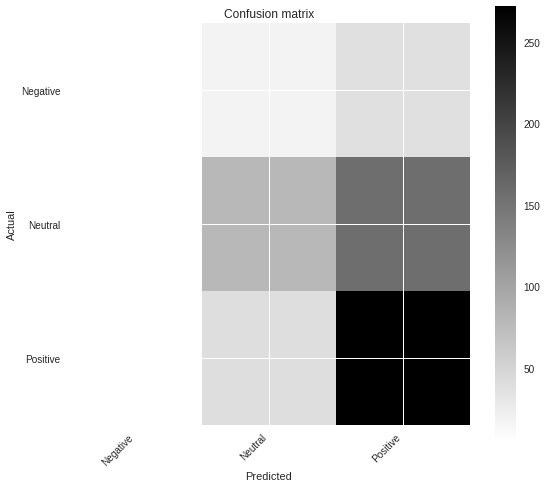

In [222]:
cnf_matrix_vader = ConfusionMatrix(y_true, y_pred_vader)
acc_score_vader = accuracy_score(y_true, y_pred_vader)


print('Accuracy Score: ', acc_score_vader)

print(cnf_matrix_vader)

cnf_matrix_vader.plot()
plt.show()

#Comapre API Performance:

## Time

In [228]:
print('Execution time by AWS: ', time_aws)
print('Execution time by Microsoft Azure: ', time_azure)
print('Execution time by IBM: ', time_ibm)
print('Execution time by Google: ', time_gcp)
print('Execution time by Vader: ', time_vader)

Execution time by AWS:  62.86798977851868
Execution time by Microsoft Azure:  3.167090654373169
Execution time by IBM:  229.88341784477234
Execution time by Google:  47.409239530563354
Execution time by Vader:  0.7608842849731445


In [0]:
Time_dict = {'AWS':time_aws,'AZURE':time_azure,'IBM':time_ibm,'GOOGLE':time_gcp,'VADER':time_vader}

In [230]:
Time_dict

{'AWS': 62.86798977851868,
 'AZURE': 3.167090654373169,
 'GOOGLE': 47.409239530563354,
 'IBM': 229.88341784477234,
 'VADER': 0.7608842849731445}

<Container object of 5 artists>

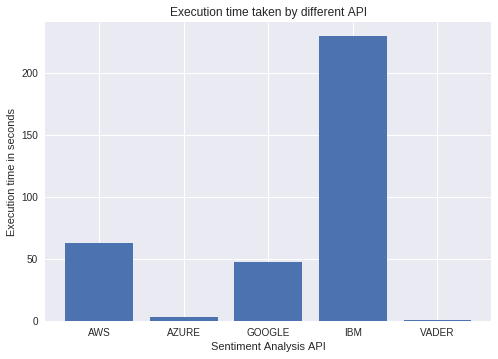

In [234]:
plt.title('Execution time taken by different API')
plt.xlabel('Sentiment Analysis API')
plt.ylabel('Execution time in seconds')
plt.bar(Time_dict.keys(), Time_dict.values())

1. AWS, AZURE, GOOGLE and IBM for this API we need to hit to the external application to get the result.
2. For Vader API, it resides locally. Hence Vader API execute fast than other APIs.
3. Also, Microsoft Azure API uses the document concept for the sentiment analysis, in which we can hit all the samples of text in one go. Thus in one hit we can the result for our dataset.
4. Whereas, other API get called one iterartion at a time.
5. We tried to use RISE Lab Ray to parallelize the API execution but as this are APIs, they are thread lock. Hence could not succeed.

## Accuracy

In [235]:
print('Sentiment Accuracy by AWS: ', acc_score_aws)
print('Sentiment Accuracy by Microsoft Azure: ', acc_score_azure)
print('Sentiment Accuracy by IBM: ', acc_score_ibm)
print('Sentiment Accuracy by Google: ', acc_score_gcp)
print('Sentiment Accuracy by Vader: ', acc_score_vader)

Sentiment Accuracy by AWS:  0.43086816720257237
Sentiment Accuracy by Microsoft Azure:  0.45980707395498394
Sentiment Accuracy by IBM:  0.5289389067524116
Sentiment Accuracy by Google:  0.5401929260450161
Sentiment Accuracy by Vader:  0.5755627009646302


In [0]:
Acc_dict = {'AWS':acc_score_aws,'AZURE':acc_score_azure,'IBM':acc_score_ibm,'GOOGLE':acc_score_gcp,'VADER':acc_score_vader}

In [237]:
Acc_dict

{'AWS': 0.43086816720257237,
 'AZURE': 0.45980707395498394,
 'GOOGLE': 0.5401929260450161,
 'IBM': 0.5289389067524116,
 'VADER': 0.5755627009646302}

<Container object of 5 artists>

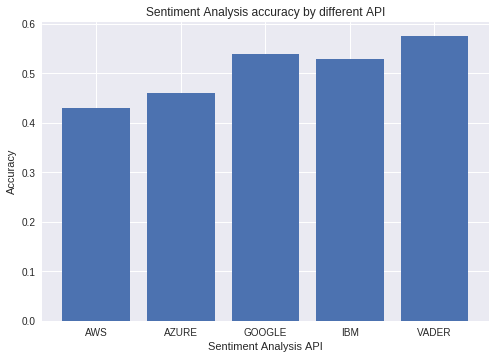

In [238]:
plt.title('Sentiment Analysis accuracy by different API')
plt.xlabel('Sentiment Analysis API')
plt.ylabel('Accuracy')
plt.bar(Acc_dict.keys(), Acc_dict.values())

1. As per the plot, we can see that the Vader API give us the better result as comapre to other APIs.
2. The response for AWS and IBM APIs is already classified as Positive, Negative and Neutral.
3. But for Google, Micorsoft Azure and Vader APIs we have overhead to classify the sentiment based on the scores.
4. This scoring systems to the text for sentiment gives us the flexibility to choose the threshold for classifying the sentiment for that text.
5. As we can see that for all the APIs the accuracy fall between 43% to 57% which is releativley less.
6. This might be the case because of incorrect labeling to the dataser under consideration.
7. If that is the case then we can expect more accuracy from the above APIs.

#Pricing

1. We can find the pricing model for AWS sentiment analysis Comprehend API here: https://aws.amazon.com/comprehend/pricing/
2. IBM: https://www.ibm.com/cloud/watson-natural-language-understanding/pricing
3. Google: https://cloud.google.com/natural-language/pricing
4. Microsoft Azure: https://azure.microsoft.com/en-us/pricing/details/cognitive-services/text-analytics/
5. Vader: Open Source - Free

1. All commercial APIs for sentiment analysis has price associated with it.
2. However, Vader API is open source.
3. Thus there is no limit on the usage. 